In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from diffusers import UNet2DConditionModel, DDPMScheduler
import matplotlib.pyplot as plt

/apps/software/standard/core/miniforge/24.3.0-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = (45, 1)
batch_size = 64
epochs = 10
lr = 2e-4
embedding_dim = 16


In [3]:
class FakeShowerDataset(Dataset):
    def __init__(self, n_samples=1000):
        self.n_samples = n_samples
        self.seq_len = image_size[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Random condition (energy): float between 10 and 100
        energy = torch.rand(1) * 90 + 10  # range [10, 100]

        # Fake "shower": sinusoid + noise based on energy
        x = torch.sin(torch.linspace(0, 3.14, self.seq_len)) * energy / 100
        x = x + 0.1 * torch.randn(self.seq_len)
        x = x.unsqueeze(0).unsqueeze(-1)  # (1, 45, 1)

        return x, energy


In [4]:
dataset = FakeShowerDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [10]:
x.shape

torch.Size([1, 45, 1])

In [11]:
model = UNet2DConditionModel(
    sample_size=image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(16, 32),
    down_block_types=("DownBlock2D", "CrossAttnDownBlock2D"),
    up_block_types=("CrossAttnUpBlock2D", "UpBlock2D"),
    cross_attention_dim=embedding_dim,
    norm_num_groups=4,
).to(device)


In [12]:
class EnergyEmbedder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.SiLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, energy):
        # energy: (batch, 1)
        x = self.net(energy)
        return x.unsqueeze(1)  # shape: (batch, 1, embedding_dim)


In [13]:
embedder = EnergyEmbedder(embedding_dim).to(device)


In [8]:
print(embedder.shape)

AttributeError: 'EnergyEmbedder' object has no attribute 'shape'

In [14]:
# Scheduler and optimizer
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(list(model.parameters()) + list(embedder.parameters()), lr=lr)

In [15]:
for epoch in range(epochs):
    for i, (x, energy) in enumerate(dataloader):
        x = x.to(device)  # (B, 1, 45, 1)
        energy = energy.to(device).unsqueeze(1)  # (B, 1)
        energy = energy.squeeze(-1)  
        #print("shape of energy: ",energy.shape)

        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()
        noise = torch.randn_like(x)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        # Energy → embedding
        cond = embedder(energy)  # shape: (B, 1, embedding_dim)
        #print("shape of cond: ",cond.shape)

        # Predict noise
        noise_pred = model(noisy_x, timesteps, encoder_hidden_states=cond).sample

        loss = nn.functional.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print(f"Epoch {epoch} Step {i} Loss: {loss.item():.4f}")

Epoch 0 Step 0 Loss: 0.8794
Epoch 1 Step 0 Loss: 0.4285
Epoch 2 Step 0 Loss: 0.2834
Epoch 3 Step 0 Loss: 0.1647
Epoch 4 Step 0 Loss: 0.1319
Epoch 5 Step 0 Loss: 0.1197
Epoch 6 Step 0 Loss: 0.1057
Epoch 7 Step 0 Loss: 0.1247
Epoch 8 Step 0 Loss: 0.1306
Epoch 9 Step 0 Loss: 0.1339


In [16]:
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_conditioned_samples(
    model, 
    embedder, 
    scheduler, 
    energies, 
    num_steps=50
):
    """
    Args:
        model: trained UNet2DConditionModel
        embedder: energy embedding network
        scheduler: trained DDPMScheduler
        energies: list of float values representing energy conditions
        num_steps: number of denoising steps (<= scheduler.config.num_train_timesteps)
    Returns:
        List of generated torch tensors, one per energy value
    """
    model.eval()
    scheduler.set_timesteps(num_steps)
    samples = []

    for energy_val in energies:
        # (1, 1) energy tensor
        energy_tensor = torch.tensor([[energy_val]], dtype=torch.float32).to(model.device)
        cond = embedder(energy_tensor)  # shape: (1, 1, embedding_dim)

        # Start from Gaussian noise
        x = torch.randn(1, 1, *model.config.sample_size).to(model.device)

        for t in scheduler.timesteps:
            noise_pred = model(x, t, encoder_hidden_states=cond).sample
            x = scheduler.step(noise_pred, t, x).prev_sample

        samples.append(x.squeeze().cpu())  # shape: (45, 1)

    return samples

In [17]:
# Example: generate for 4 different incident energies
incident_energies = [10.0, 30.0, 60.0, 90.0]
generated = generate_conditioned_samples(model, embedder, scheduler, incident_energies)


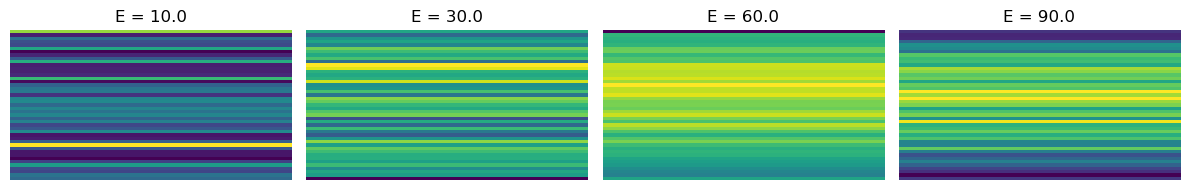

In [18]:
# Plotting
fig, axs = plt.subplots(1, len(generated), figsize=(12, 2))
for i, (img, e) in enumerate(zip(generated, incident_energies)):
    img_vis = img if img.ndim == 2 else img.unsqueeze(1)  # ensure 2D for imshow
    axs[i].imshow(img_vis, cmap="viridis", aspect="auto")
    axs[i].set_title(f"E = {e}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


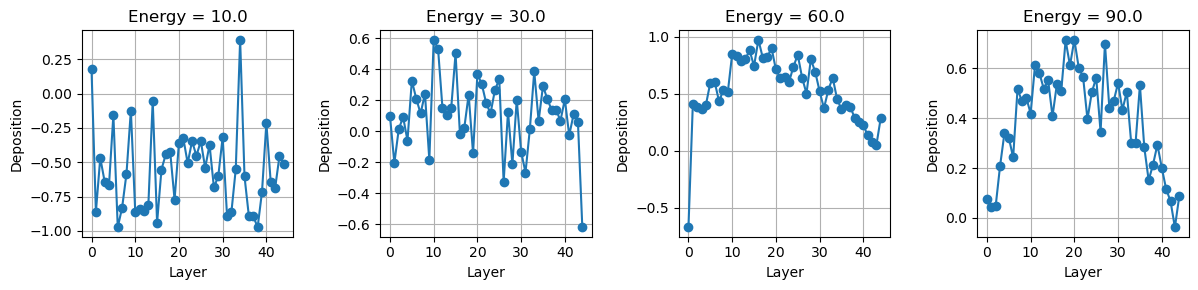

In [19]:
import matplotlib.pyplot as plt

# Plot as line plots
fig, axs = plt.subplots(1, len(generated), figsize=(12, 3))

for i, (img, e) in enumerate(zip(generated, incident_energies)):
    # Ensure shape is (45,) regardless of how it comes out
    if img.ndim > 1:
        img = img.squeeze()

    axs[i].plot(img.numpy(), marker='o')
    axs[i].set_title(f"Energy = {e}")
    axs[i].set_xlabel("Layer")
    axs[i].set_ylabel("Deposition")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [27]:
dataset = FakeShowerDataset()
target_energy = 60.0
tolerance = 1e-1

for i in range(len(dataset)):
    x, energy = dataset[i]
    if torch.isclose(energy, torch.tensor(target_energy), atol=tolerance):
        print(f"Found at index {i}, energy = {energy.item():.2f}")
        break

Found at index 268, energy = 59.96


In [28]:
x.shape

torch.Size([1, 45, 1])

torch.Size([45])


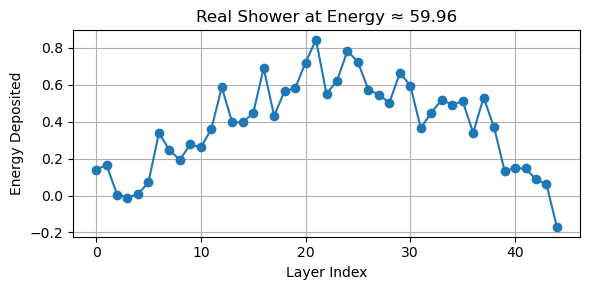

In [29]:
x = x.squeeze()  # shape: (45,) or (45, 1)
if x.ndim > 1:
    x = x.squeeze(-1)
print(x.shape)
plt.figure(figsize=(6, 3))
plt.plot(x.cpu().numpy(), marker='o')
plt.title(f"Real Shower at Energy ≈ {energy.item():.2f}")
plt.xlabel("Layer Index")
plt.ylabel("Energy Deposited")
plt.grid(True)
plt.tight_layout()
plt.show()


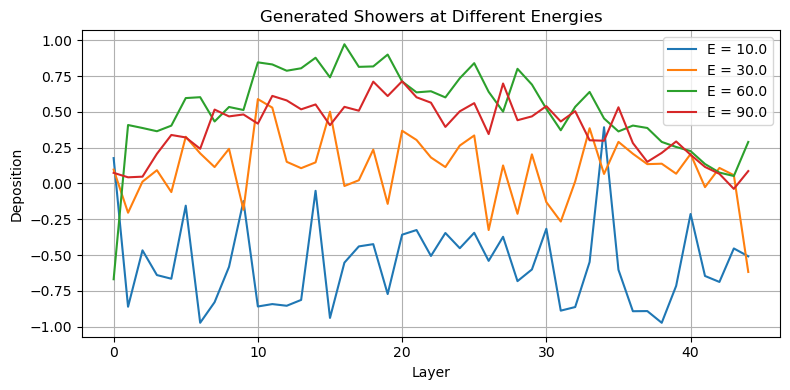

In [20]:
plt.figure(figsize=(8, 4))
for img, e in zip(generated, incident_energies):
    img = img.squeeze()
    plt.plot(img.numpy(), label=f"E = {e}")
plt.xlabel("Layer")
plt.ylabel("Deposition")
plt.title("Generated Showers at Different Energies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()